In [1]:
import os 
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import cdms
from rawio.IO import *
import pandas as pd
import qetpy as qp
from array import array

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


In [2]:
### This cell tries to setup a convertion factor, i.e once input is read from raw data in ADC units, convert it to Current (Amps)

'''
for CUTE

fs = 6.25e5 #sample points in per second
Rshunt = 5.0e-3 # shunt resistance on the TES circuit diagram
Rfb = 5000.0 # feedback resistance on the TES circuit diagram
ADCperVolt = 65536.0/8.0 # the number of ADC bins per V for the readout (16 bit digitizer going from -4V to 4V, hence 2^16 divided by 8)
LoopRatio = 2.4 # SQUID turn ratio at CUTE
scale = Rfb*ADCperVolt*LoopRatio

'''


### For UMN 
fs = 1.25e6 #sample points in per second
Rshunt = 8.0e-3 # shunt resistance on the TES circuit diagram
Rfb = 1000 # feedback resistance on the TES circuit diagram
ADCperVolt = 16384./2.5 # the number of ADC bins per V for the readout (14 bit digitizer going from -1.25V to +1.25V, hence 2^14 divided by 2.5)
LoopGain = 10000 # Phonon feedback gain (=10 (input/fb turn ratio) * 1000 Ohm fb resistor)
DG = 20 # driver gain
scale = ADCperVolt*LoopGain

In [3]:
# raw-events path: /data/chocula/fritts/data/k100proc/midasraw/byseries/
#frittsdir='/data/chocula/fritts/data/k100proc/midasraw/byseries/07220420_0842/07220420_0842_F0011.mid.gz'
frittsdir='/data/chocula/fritts/data/k100proc/midasraw/byseries/'
voltages = ['0V','4V','20V','65V','84V']
series = {
    '0V' : '07220822_1828',
    '4V' : '07220826_1219',
    '20V' : '07220826_1536',
    '65V' : '07220826_2007',
    '84V' : '07220827_1153'
}
#events= cdms.rawio.IO.getRawEvents(frittsdir,series,maxNumEvents=1000)

events={}
for volt in voltages:
    events[volt] = cdms.rawio.IO.getRawEvents(frittsdir,series[volt],maxNumEvents=1000)

The file is: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220822_1828/07220822_1828_F0001.mid.gz

Opened raw midas file: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220822_1828/07220822_1828_F0001.mid.gz
The file is: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220826_1219/07220826_1219_F0001.mid.gz

Opened raw midas file: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220826_1219/07220826_1219_F0001.mid.gz
The file is: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220826_1536/07220826_1536_F0001.mid.gz

Opened raw midas file: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220826_1536/07220826_1536_F0001.mid.gz
The file is: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220826_2007/07220826_2007_F0001.mid.gz

Opened raw midas file: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220826_2007/07220826_2007_F0001.mid.gz
The file is: /data/chocula/fritts/data/k100proc/midasraw/byseries//07220827_1153/07220827_11

In [4]:
events['0V'].head(2)

Z1  \
                                                                  QI   
72208221828 10000  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            10001  [65532, 65532, 65532, 65532, 65532, 65532, 655...   

                                                                      \
                                                                  QO   
72208221828 10000  [41553, 41604, 41507, 41578, 41506, 41575, 415...   
            10001  [41530, 41563, 41535, 41553, 41527, 41527, 415...   

                                                                      \
                                                                  PA   
72208221828 10000  [2809, 2811, 2809, 2811, 2807, 2809, 2810, 281...   
            10001  [2796, 2794, 2796, 2793, 2796, 2793, 2796, 279...   

                                                                      \
                                                                  PB   
72208221828 10000  [2476, 2477, 2475, 2479, 2476, 2476, 2479, 247...   
            10001  [2464, 2461, 2463, 2460, 2461, 2461, 2463, 246...   

                                                                      \
                                                                  PC   
72208221828 10000  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
            10001  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                                      \
                                                                  PD   
72208221828 10000  [2711, 2713, 2711, 2707, 2708, 2706, 2710, 271...   
            10001  [2695, 2694, 2694, 2693, 2693, 2694, 2691, 269...   

                                                                  Z3  \
                                                                  QI   
72208221828 10000  [33718, 33722, 33722, 33719, 33713, 33717, 337...   
            10001  [33707, 33705, 33705, 33707, 33705, 33705, 337...   

                                                                      \
                                                                  QO   
72208221828 10000  [33564, 33557, 33563, 33563, 33566, 33555, 335...   
            10001  [33562, 33566, 33560, 33564, 33567, 33562, 335...   

                                                                      \
                                                                  PA   
72208221828 10000  [3122, 3122, 3125, 3126, 3124, 3126, 3123, 312...   
            10001  [3104, 3103, 3104, 3105, 3104, 3107, 3108, 310...   

                                                                      \
                                                                  PB   
72208221828 10000  [2597, 2599, 2603, 2602, 2602, 2603, 2601, 260...   
            10001  [2589, 2584, 2586, 2588, 2584, 2586, 2588, 258...   

                                                                      \
                                                                  PC   
72208221828 10000  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
            10001  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                                      
                                                                  PD  
72208221828 10000  [2685, 2682, 2683, 2684, 2682, 2683, 2684, 268...  
            10001  [2665, 2663, 2666, 2669, 2668, 2663, 2667, 266...

In [5]:
channels = ['PA','PB','PC','PD','PE','PF']
noise_psd_cut = {}
noise_psd_nocut = {}
cut = {}


traces = {}
tracesAmps = {}
for volt in voltages: 
    traces[volt] = {}
    tracesAmps[volt] = {}
    noise_psd_cut[volt] = {}
    noise_psd_nocut[volt] = {}
    cut[volt] = {}
    

In [6]:

for volt in voltages:
    traces[volt]['PB'] = events[volt]['Z1']['PA']
    traces[volt]['PA'] = events[volt]['Z1']['PB']
    traces[volt]['PD'] = events[volt]['Z1']['PD']
    traces[volt]['PC'] = events[volt]['Z3']['PA']
    traces[volt]['PF'] = events[volt]['Z3']['PB']
    traces[volt]['PE'] = events[volt]['Z3']['PD']

        
print('Done')

for volt in voltages:
    print('****** %s ******'%(volt))
    conv2Amp = 1./(scale*DG)
    for chan in traces[volt].keys():
        temp = []
        for i in traces[volt][chan][int(series[volt]),:].values[:]:
            temp.append(i*conv2Amp)
        tracesAmps[volt][chan] = np.asarray(temp)
        print('  Traces in %s = %d'%(chan,len(tracesAmps[volt][chan])))
        


# for chan in traces.keys():
#     temp = []
#     conv2Amp = 1./(scale*DG)
#     for i in traces[chan][int(series),:].values[:]:
#         temp.append(i*conv2Amp)
#     tracesAmps[chan] = np.asarray(temp)
#     print(chan,' : ',tracesAmps[chan].shape)
#    print('Traces in %s = %d'%(key,len(tracesAmps[key])))

Done
****** 0V ******
  Traces in PB = 1000
  Traces in PA = 1000
  Traces in PD = 1000
  Traces in PC = 1000
  Traces in PF = 1000
  Traces in PE = 1000
****** 4V ******
  Traces in PB = 1000
  Traces in PA = 1000
  Traces in PD = 1000
  Traces in PC = 1000
  Traces in PF = 1000
  Traces in PE = 1000
****** 20V ******
  Traces in PB = 1000
  Traces in PA = 1000
  Traces in PD = 1000
  Traces in PC = 1000
  Traces in PF = 1000
  Traces in PE = 1000
****** 65V ******
  Traces in PB = 1000
  Traces in PA = 1000
  Traces in PD = 1000
  Traces in PC = 1000
  Traces in PF = 1000
  Traces in PE = 1000
****** 84V ******
  Traces in PB = 1000
  Traces in PA = 1000
  Traces in PD = 1000
  Traces in PC = 1000
  Traces in PF = 1000
  Traces in PE = 1000


In [7]:
tracesAmps.keys()

dict_keys(['0V', '4V', '20V', '65V', '84V'])

In [8]:
for volt in voltages:
    print('****** %s ******'%(volt))
    for i,chan in enumerate(channels):
        cut[volt][chan] = qp.autocuts(tracesAmps[volt][chan], fs)    
        noise_psd_nocut[volt][chan] = qp.calc_psd(tracesAmps[volt][chan], fs=fs, folded_over=True)
        noise_psd_cut[volt][chan] = qp.calc_psd(tracesAmps[volt][chan][cut[volt][chan]], fs=fs, folded_over=True)
        print('  %s : Cut efficieny is %0.3f'%(chan, np.sum(cut[volt][chan])/len(tracesAmps[volt][chan])))

****** 0V ******
  PA : Cut efficieny is 0.267
  PB : Cut efficieny is 0.288
  PC : Cut efficieny is 0.216
  PD : Cut efficieny is 0.165
  PE : Cut efficieny is 0.209
  PF : Cut efficieny is 0.305
****** 4V ******
  PA : Cut efficieny is 0.266
  PB : Cut efficieny is 0.198
  PC : Cut efficieny is 0.188
  PD : Cut efficieny is 0.141
  PE : Cut efficieny is 0.177
  PF : Cut efficieny is 0.280
****** 20V ******
  PA : Cut efficieny is 0.176
  PB : Cut efficieny is 0.198
  PC : Cut efficieny is 0.153
  PD : Cut efficieny is 0.104
  PE : Cut efficieny is 0.203
  PF : Cut efficieny is 0.168
****** 65V ******
  PA : Cut efficieny is 0.114
  PB : Cut efficieny is 0.085
  PC : Cut efficieny is 0.100
  PD : Cut efficieny is 0.090
  PE : Cut efficieny is 0.129
  PF : Cut efficieny is 0.102
****** 84V ******
  PA : Cut efficieny is 0.102
  PB : Cut efficieny is 0.145
  PC : Cut efficieny is 0.088
  PD : Cut efficieny is 0.106
  PE : Cut efficieny is 0.099
  PF : Cut efficieny is 0.115


<>:10: DeprecationWarning: invalid escape sequence \s
<>:10: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_2877270/1701864596.py:10: DeprecationWarning: invalid escape sequence \s
  axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')


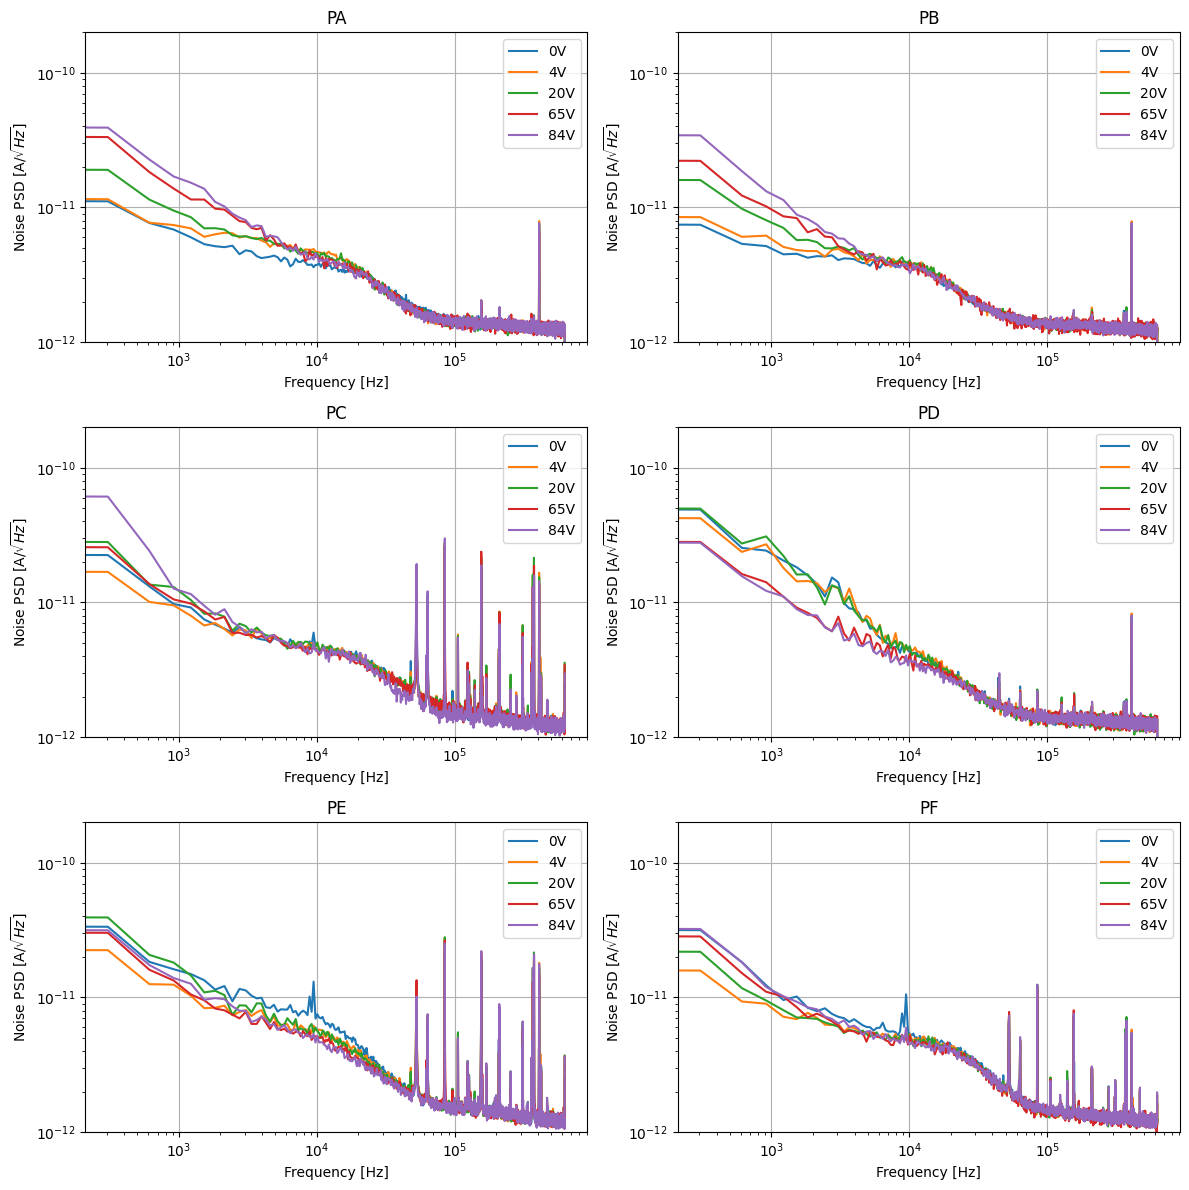

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(12,12))
pp=[(0,0), (0,1), (1,0), (1,1),(2,0),(2,1)]
for i,chan in enumerate(channels):
    for volt in voltages:
        axs[pp[i]].loglog(noise_psd_cut[volt][chan][0],np.sqrt(noise_psd_cut[volt][chan][1]),label=volt)
    axs[pp[i]].legend(loc='upper right')
    axs[pp[i]].grid()
    axs[pp[i]].set_title(chan)
    axs[pp[i]].set_xlabel('Frequency [Hz]')
    axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')
    axs[pp[i]].set_ylim([1e-12,2e-10])
fig.tight_layout()

# IterCut

In [10]:
### Initialization
cut_pars = {'sigma':2.5}
cminmax = {}
cbaseline = {}
cslope = {}
IC_cuts = {
    'def' : 'No cut',
    'minmax' : 'minmax',
    'baseline' : '+ baseline outlier',
    'slope' : '+ baseline slope'
}
noise_psd_ic_cuts = {}

for volt in voltages: 
    cminmax[volt] = {}
    cbaseline[volt] = {}
    cslope[volt] = {}
    noise_psd_ic_cuts[volt] = {}
    for chan in channels:
        noise_psd_ic_cuts[volt][chan] = {}
    


## Calculation
for volt in voltages:
    print('****** %s ******'%(volt))
    for i,chan in enumerate(channels):
        IC_temp = qp.IterCut(tracesAmps[volt][chan], fs)
        cminmax[volt][chan] = IC_temp.minmaxcut(cut_pars)
        cbaseline[volt][chan] = IC_temp.baselinecut(cut_pars)
        cslope[volt][chan] = IC_temp.slopecut(cut_pars)
        noise_psd_ic_cuts[volt][chan]['def'] = qp.calc_psd(tracesAmps[volt][chan], fs=fs, folded_over=True)
        cmask = cminmax[volt][chan]
        noise_psd_ic_cuts[volt][chan]['minmax'] = qp.calc_psd(tracesAmps[volt][chan][cmask], fs=fs, folded_over=True)
        cmask = cmask & cbaseline[volt][chan]
        noise_psd_ic_cuts[volt][chan]['baseline'] = qp.calc_psd(tracesAmps[volt][chan][cmask], fs=fs, folded_over=True)
        cmask = cmask & cslope[volt][chan]
        noise_psd_ic_cuts[volt][chan]['slope'] = qp.calc_psd(tracesAmps[volt][chan][cmask], fs=fs, folded_over=True)
        print('  %s calculated..'%(chan))
        
print('Done!')

****** 0V ******
  PA calculated..
  PB calculated..
  PC calculated..
  PD calculated..
  PE calculated..
  PF calculated..
****** 4V ******
  PA calculated..
  PB calculated..
  PC calculated..
  PD calculated..
  PE calculated..
  PF calculated..
****** 20V ******
  PA calculated..
  PB calculated..
  PC calculated..
  PD calculated..
  PE calculated..
  PF calculated..
****** 65V ******
  PA calculated..
  PB calculated..
  PC calculated..
  PD calculated..
  PE calculated..
  PF calculated..
****** 84V ******
  PA calculated..
  PB calculated..
  PC calculated..
  PD calculated..
  PE calculated..
  PF calculated..
Done!


<>:20: DeprecationWarning: invalid escape sequence \s
<>:20: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_2877270/148728976.py:20: DeprecationWarning: invalid escape sequence \s
  axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')


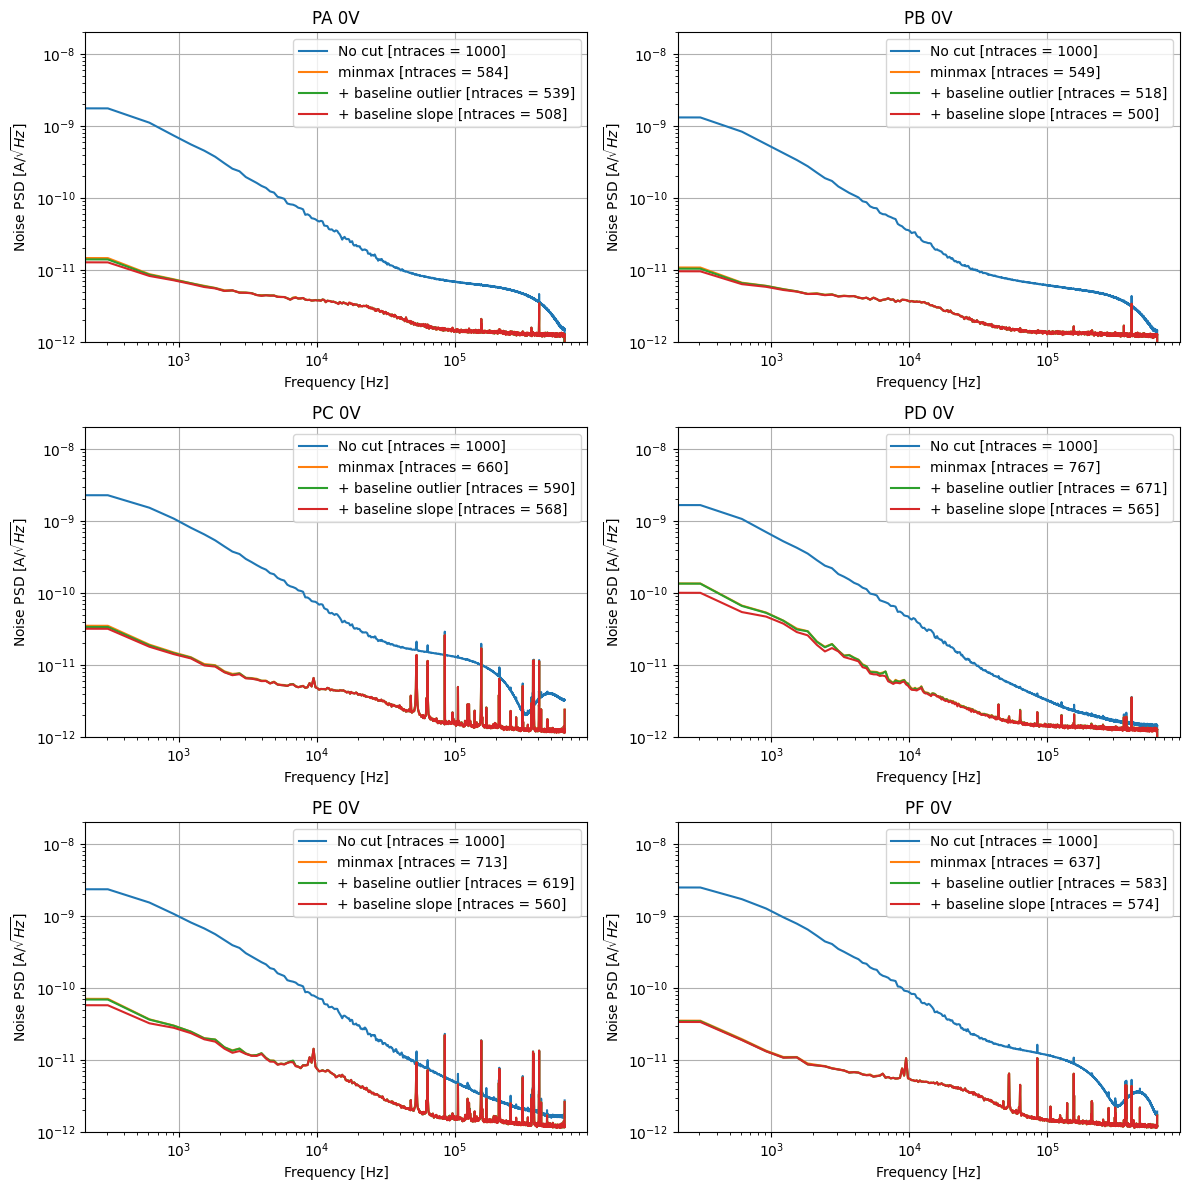

In [11]:
volt = '0V'
fig, axs = plt.subplots(3, 2, figsize=(12,12))
pp=[(0,0), (0,1), (1,0), (1,1),(2,0),(2,1)]
for i,chan in enumerate(channels):
    for cut in IC_cuts.keys():
        ntraces = -1
        if(cut == 'def'):
            ntraces = len(tracesAmps[volt][chan])
        elif(cut=='minmax'):
            ntraces = np.sum(cminmax[volt][chan])
        elif(cut=='baseline'):
            ntraces = np.sum(cbaseline[volt][chan])
        elif(cut=='slope'):
            ntraces = np.sum(cslope[volt][chan])
        axs[pp[i]].loglog(noise_psd_ic_cuts[volt][chan][cut][0],np.sqrt(noise_psd_ic_cuts[volt][chan][cut][1]),label=IC_cuts[cut]+' [ntraces = %d]'%(ntraces))
    axs[pp[i]].legend(loc='upper right')
    axs[pp[i]].grid()
    axs[pp[i]].set_title(chan+' %s'%(volt))
    axs[pp[i]].set_xlabel('Frequency [Hz]')
    axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')
    axs[pp[i]].set_ylim([1e-12,2e-8])
fig.tight_layout()

<>:20: DeprecationWarning: invalid escape sequence \s
<>:20: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_2877270/3891831023.py:20: DeprecationWarning: invalid escape sequence \s
  axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')


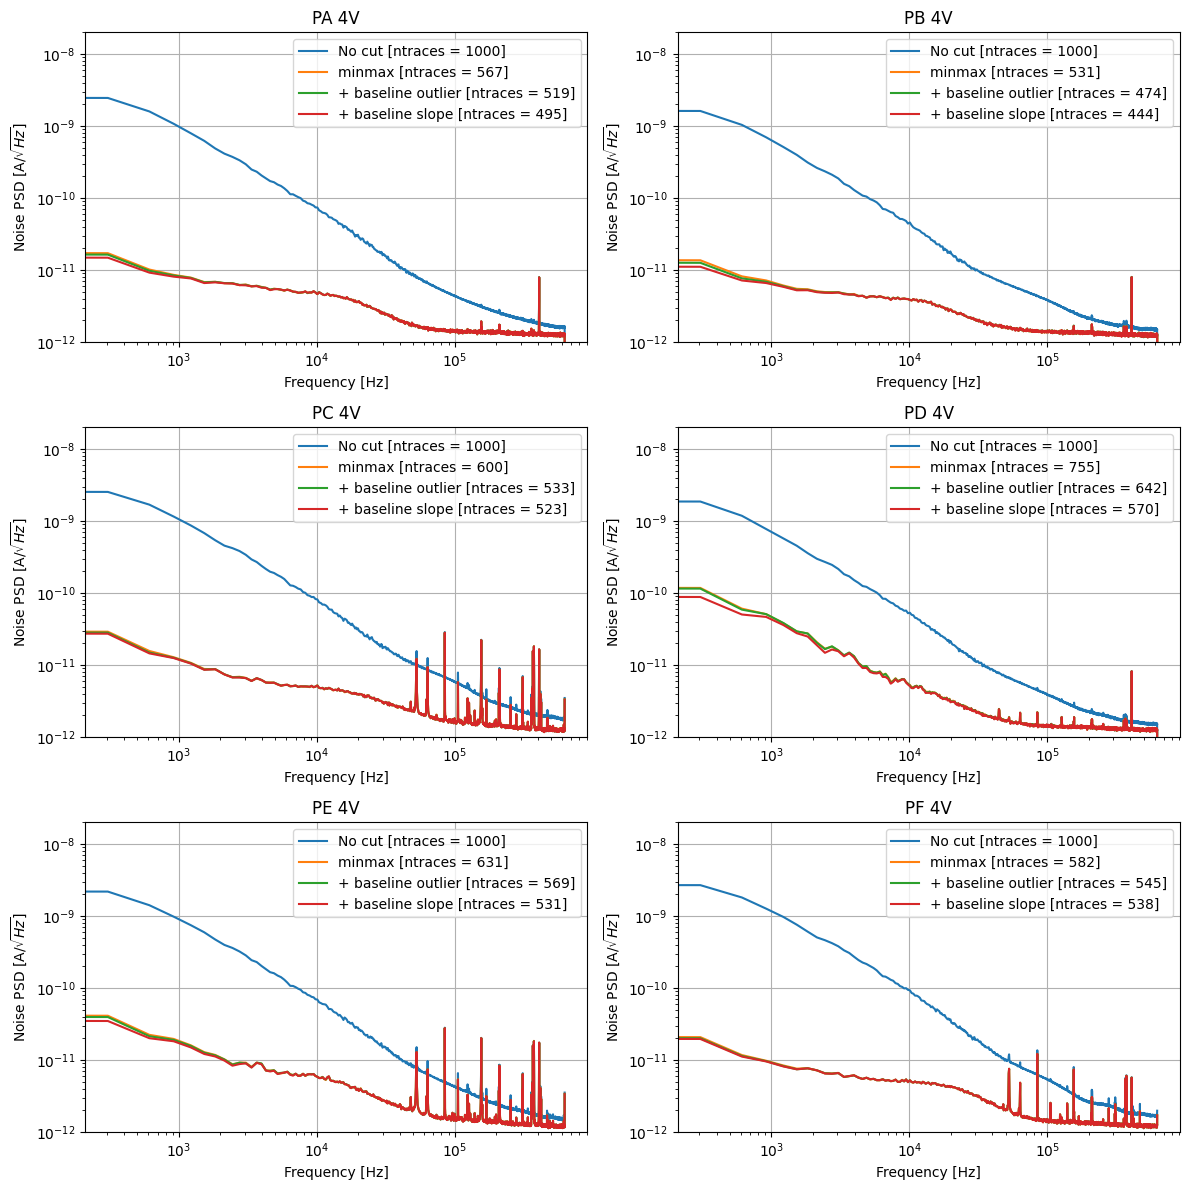

In [12]:
volt = '4V'
fig, axs = plt.subplots(3, 2, figsize=(12,12))
pp=[(0,0), (0,1), (1,0), (1,1),(2,0),(2,1)]
for i,chan in enumerate(channels):
    for cut in IC_cuts.keys():
        ntraces = -1
        if(cut == 'def'):
            ntraces = len(tracesAmps[volt][chan])
        elif(cut=='minmax'):
            ntraces = np.sum(cminmax[volt][chan])
        elif(cut=='baseline'):
            ntraces = np.sum(cbaseline[volt][chan])
        elif(cut=='slope'):
            ntraces = np.sum(cslope[volt][chan])
        axs[pp[i]].loglog(noise_psd_ic_cuts[volt][chan][cut][0],np.sqrt(noise_psd_ic_cuts[volt][chan][cut][1]),label=IC_cuts[cut]+' [ntraces = %d]'%(ntraces))
    axs[pp[i]].legend(loc='upper right')
    axs[pp[i]].grid()
    axs[pp[i]].set_title(chan+' %s'%(volt))
    axs[pp[i]].set_xlabel('Frequency [Hz]')
    axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')
    axs[pp[i]].set_ylim([1e-12,2e-8])
fig.tight_layout()

<>:20: DeprecationWarning: invalid escape sequence \s
<>:20: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_2877270/374389795.py:20: DeprecationWarning: invalid escape sequence \s
  axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')


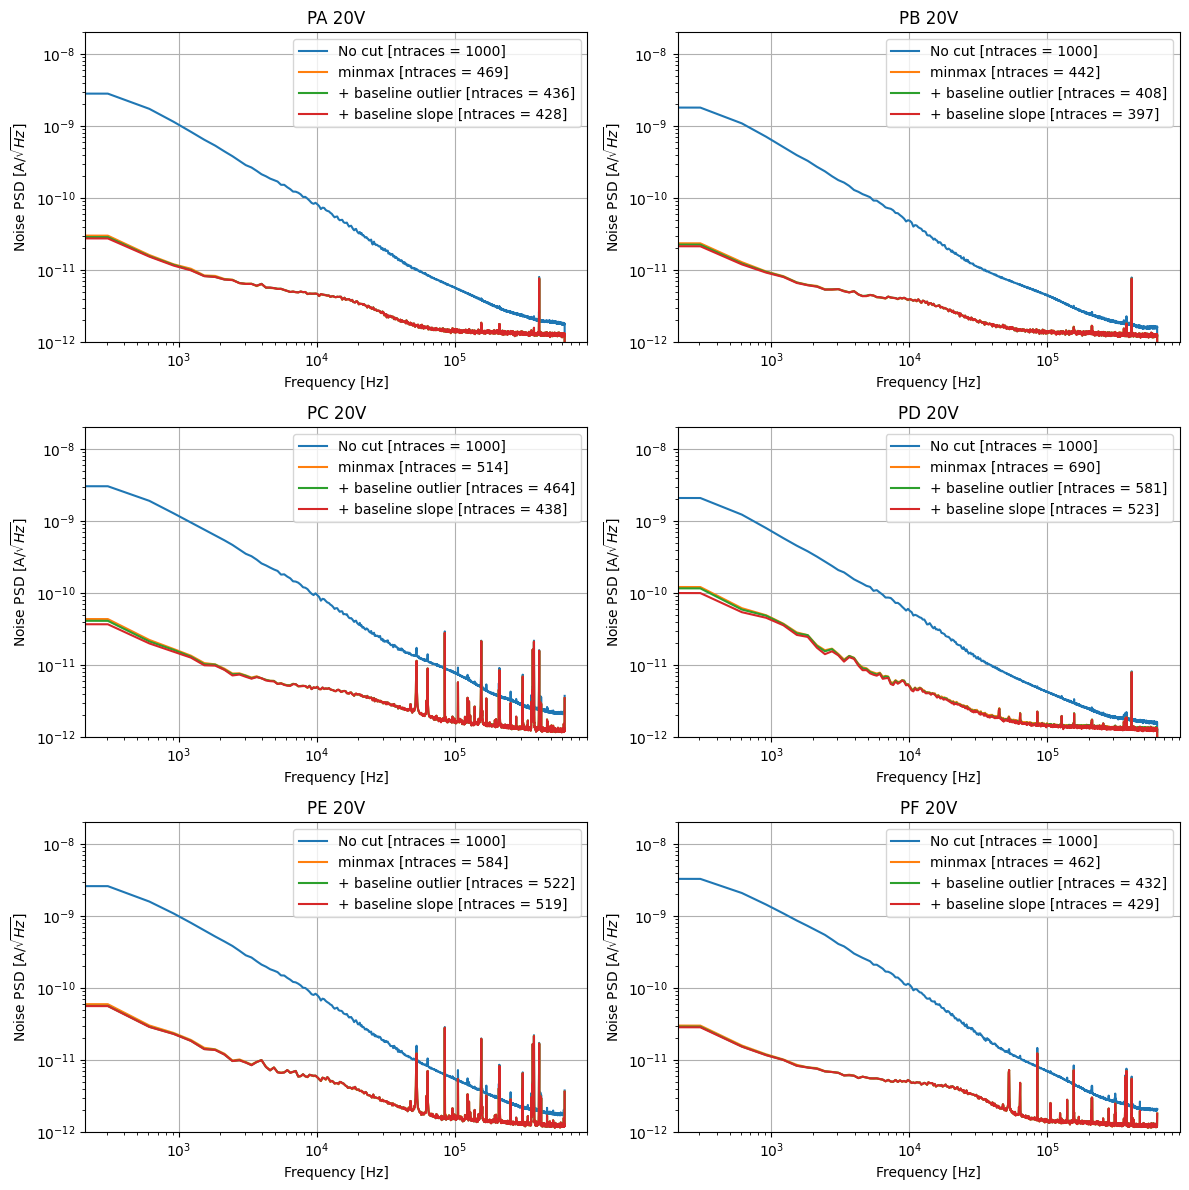

In [13]:
volt = '20V'
fig, axs = plt.subplots(3, 2, figsize=(12,12))
pp=[(0,0), (0,1), (1,0), (1,1),(2,0),(2,1)]
for i,chan in enumerate(channels):
    for cut in IC_cuts.keys():
        ntraces = -1
        if(cut == 'def'):
            ntraces = len(tracesAmps[volt][chan])
        elif(cut=='minmax'):
            ntraces = np.sum(cminmax[volt][chan])
        elif(cut=='baseline'):
            ntraces = np.sum(cbaseline[volt][chan])
        elif(cut=='slope'):
            ntraces = np.sum(cslope[volt][chan])
        axs[pp[i]].loglog(noise_psd_ic_cuts[volt][chan][cut][0],np.sqrt(noise_psd_ic_cuts[volt][chan][cut][1]),label=IC_cuts[cut]+' [ntraces = %d]'%(ntraces))
    axs[pp[i]].legend(loc='upper right')
    axs[pp[i]].grid()
    axs[pp[i]].set_title(chan+' %s'%(volt))
    axs[pp[i]].set_xlabel('Frequency [Hz]')
    axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')
    axs[pp[i]].set_ylim([1e-12,2e-8])
fig.tight_layout()

<>:20: DeprecationWarning: invalid escape sequence \s
<>:20: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_2877270/584453991.py:20: DeprecationWarning: invalid escape sequence \s
  axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')


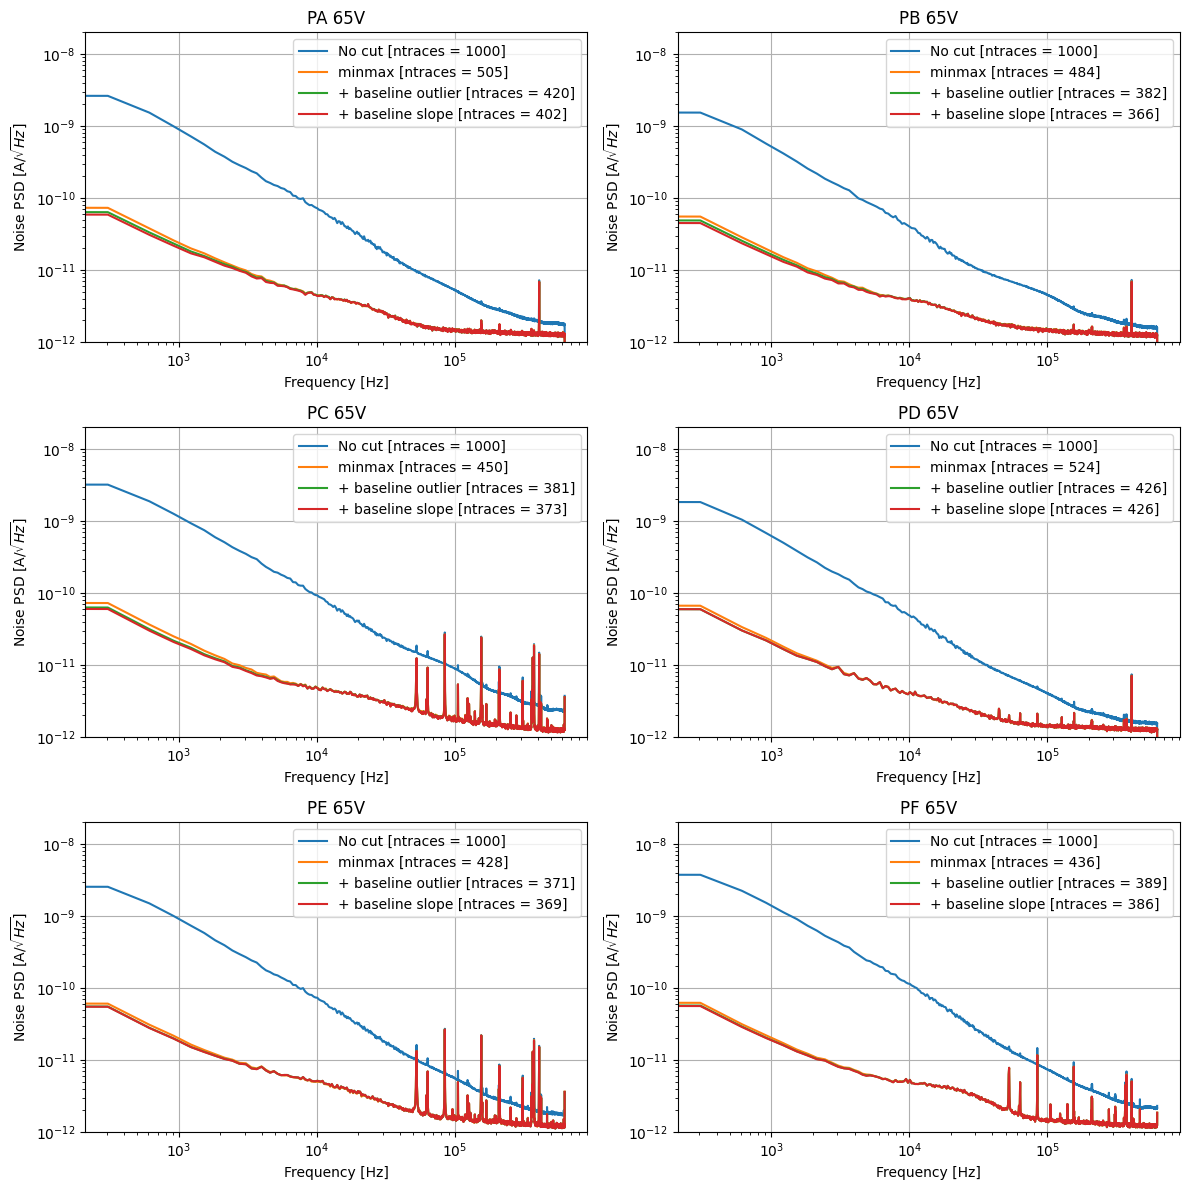

In [14]:
volt = '65V'
fig, axs = plt.subplots(3, 2, figsize=(12,12))
pp=[(0,0), (0,1), (1,0), (1,1),(2,0),(2,1)]
for i,chan in enumerate(channels):
    for cut in IC_cuts.keys():
        ntraces = -1
        if(cut == 'def'):
            ntraces = len(tracesAmps[volt][chan])
        elif(cut=='minmax'):
            ntraces = np.sum(cminmax[volt][chan])
        elif(cut=='baseline'):
            ntraces = np.sum(cbaseline[volt][chan])
        elif(cut=='slope'):
            ntraces = np.sum(cslope[volt][chan])
        axs[pp[i]].loglog(noise_psd_ic_cuts[volt][chan][cut][0],np.sqrt(noise_psd_ic_cuts[volt][chan][cut][1]),label=IC_cuts[cut]+' [ntraces = %d]'%(ntraces))
    axs[pp[i]].legend(loc='upper right')
    axs[pp[i]].grid()
    axs[pp[i]].set_title(chan+' %s'%(volt))
    axs[pp[i]].set_xlabel('Frequency [Hz]')
    axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')
    axs[pp[i]].set_ylim([1e-12,2e-8])
fig.tight_layout()

<>:20: DeprecationWarning: invalid escape sequence \s
<>:20: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_2877270/4035567921.py:20: DeprecationWarning: invalid escape sequence \s
  axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')


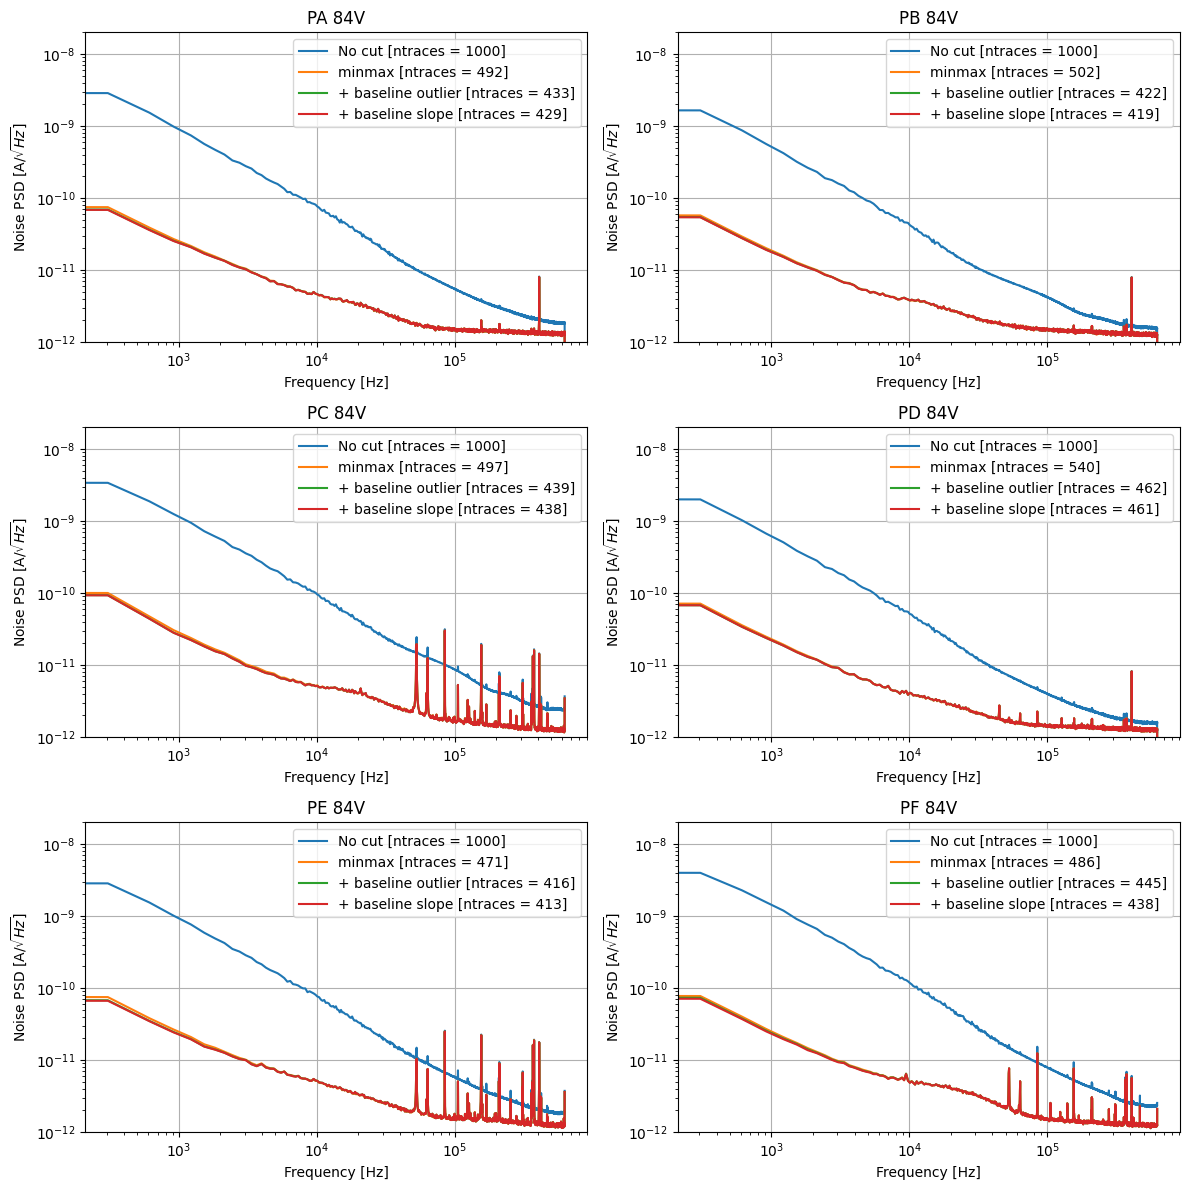

In [15]:
volt = '84V'
fig, axs = plt.subplots(3, 2, figsize=(12,12))
pp=[(0,0), (0,1), (1,0), (1,1),(2,0),(2,1)]
for i,chan in enumerate(channels):
    for cut in IC_cuts.keys():
        ntraces = -1
        if(cut == 'def'):
            ntraces = len(tracesAmps[volt][chan])
        elif(cut=='minmax'):
            ntraces = np.sum(cminmax[volt][chan])
        elif(cut=='baseline'):
            ntraces = np.sum(cbaseline[volt][chan])
        elif(cut=='slope'):
            ntraces = np.sum(cslope[volt][chan])
        axs[pp[i]].loglog(noise_psd_ic_cuts[volt][chan][cut][0],np.sqrt(noise_psd_ic_cuts[volt][chan][cut][1]),label=IC_cuts[cut]+' [ntraces = %d]'%(ntraces))
    axs[pp[i]].legend(loc='upper right')
    axs[pp[i]].grid()
    axs[pp[i]].set_title(chan+' %s'%(volt))
    axs[pp[i]].set_xlabel('Frequency [Hz]')
    axs[pp[i]].set_ylabel('Noise PSD [A/$\sqrt{Hz}$]')
    axs[pp[i]].set_ylim([1e-12,2e-8])
fig.tight_layout()

In [ ]:
series

In [19]:
voltages

['0V', '4V', '20V', '65V', '84V']